In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

Colab notebook: https://colab.research.google.com/drive/1RWFmrEPNjkjXVI3sMEfwfWYnqzD-ia4s?usp=sharing

Pada tulisan dan kode ini, akan membahas tentang penerapan machine learning dan deep learning terhadap suatu case study untuk kinerja dari mesin turbin gas berdasarkan data dari beberapa sensor dan memprediksi kemungkinan adanya kerusakan pada mesin tersebut. Secara garis besar, tipe pembelajaran yang digunakan pada case study ini adalah supervised learning dengan data yang bersifat time series. Tools yang digunakan pada case study ini adalah Python versi 3.9 dengan library yang terinstall yaitu Jupyter Notebook, Scikit-learn, dan Tensorflow Keras. Hasil yang diharapkan dalam case study ini adalah prediksi dari nilai-nilai sensor berdasarkan behavioral keseluruhan dari data sehingga memungkinkan untuk melakukan fault detection nantinya.

# Data Preparation

Dataset yang digunakan dalam case study ini adalah data dari mesin turbin gas milik salah satu perusahaan minyak dan gas bumi yang merupakan salah satu kontraktor kontrak kerja sama (KKKS) dari SKK MIGAS. Dataset memiliki 161788 baris data kesehatan komponen gearbox dari mesin dengan sampling rate dari data diambil setiap 5 menit mulai dari tanggal 26 Juli 2021 pukul 05:45 sampai dengan 8 Februari 2023 pukul 00:00. Dataset memiliki 31 feature tidak termasuk Timestamp, yang terdiri dari kecepatan turbin dalam rpm, sensor getaran dalam mm, dan sensor suhu dalam derajat celsius. 

Tujuan pada case study ini adalah untuk memprediksi terjadinya kerusakan pada mesin turbin yang ditandai dengan penurunan kecepatan turbin secara mendadak.

In [3]:
df = pd.read_csv('BLD-LGC PTGBX 26 JUL21-8FEB23_edited.csv')
df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='mixed')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161788 entries, 0 to 161787
Data columns (total 32 columns):
 #   Column                                 Non-Null Count   Dtype         
---  ------                                 --------------   -----         
 0   Timestamp                              161788 non-null  datetime64[ns]
 1   PT N2 'C' Speed                        161788 non-null  float64       
 2   Gear High Speed Drive End X Vibr       161788 non-null  float64       
 3   Gear High Speed Drive End Y Vibr       161788 non-null  float64       
 4   Gear High Speed Non-Drive End X Vibr   161788 non-null  float64       
 5   Gear High Speed Non-Drive End Y Vibr   161788 non-null  float64       
 6   Gear LS Shaft Axial Displ 1            161788 non-null  float64       
 7   Gear LS Shaft Axial Displ 2            161788 non-null  float64       
 8   Gear Low Speed Drive End X Vibr        161788 non-null  float64       
 9   Gear Low Speed DriveEnd Y Vibr         161788 no

In [4]:
df.head()

Timestamp  PT N2 'C' Speed  Gear High Speed Drive End X Vibr  \
0 2021-07-26 05:45:00      5128.723145                          0.296389   
1 2021-07-26 05:50:00      5130.262207                          0.294855   
2 2021-07-26 05:55:00      5121.144531                          0.301340   
3 2021-07-26 06:00:00      5084.938965                          0.308058   
4 2021-07-26 06:05:00      5090.241699                          0.313758   

   Gear High Speed Drive End Y Vibr  Gear High Speed Non-Drive End X Vibr  \
0                          0.413373                              0.324846   
1                          0.405914                              0.325042   
2                          0.405914                              0.325830   
3                          0.412083                              0.325131   
4                          0.430409                              0.322932   

   Gear High Speed Non-Drive End Y Vibr  Gear LS Shaft Axial Displ 1  \
0                              0.491988                    10.041477   
1                              0.491340                    10.247612   
2                              0.488259                    10.378461   
3                              0.495821                    10.512401   
4                              0.492476                    10.477362   

   Gear LS Shaft Axial Displ 2  Gear Low Speed Drive End X Vibr  \
0                    10.557626                         0.379022   
1                    10.784430                         0.377899   
2                    10.921785                         0.378085   
3                    11.064705                         0.373516   
4                    11.035732                         0.378831   

   Gear Low Speed DriveEnd Y Vibr  ...  Gear LS Drive End Jrnl Brg Temp  \
0                        0.364291  ...                       196.280426   
1                        0.370086  ...                       196.279938   
2                        0.366067  ...                       197.281021   
3                        0.360375  ...                       197.281509   
4                        0.362193  ...                       197.281021   

   Gear LS Inboard Thrust Brg Temp  LO Supply Press  LO Cooler Outlet Temp  \
0                       127.332596        22.722622             106.153740   
1                       128.343506        22.721077             107.099617   
2                       128.869064        22.755575             108.105850   
3                       129.344574        22.786861             109.097611   
4                       129.344574        22.748289             109.106941   

   Pt Thrust Brg Temp  Pt Coupling End Temp  Pt Disch End Temp  \
0          139.316666            175.296387         188.311005   
1          140.253220            175.291733         188.305359   
2          141.249649            175.291733         188.305847   
3          141.249649            175.296387         186.298523   
4          141.249649            175.296387         186.323547   

   PT Rim Cooling 1&2 Temp  PT Rim Cooling 3&4 Temp  \
0               779.865906               780.616089   
1               786.046692               786.820435   
2               788.598450               789.264954   
3               789.723938               790.908203   
4               787.269226               788.036560   

   Gear LS Non-Drive End Jrnl Brg Temp  
0                           194.377380  
1                           195.333084  
2                           196.334168  
3                           196.329010  
4                           195.362763  

[5 rows x 32 columns]

array([<Axes: xlabel='Timestamp'>, <Axes: xlabel='Timestamp'>,
       <Axes: xlabel='Timestamp'>, <Axes: xlabel='Timestamp'>,
       <Axes: xlabel='Timestamp'>, <Axes: xlabel='Timestamp'>,
       <Axes: xlabel='Timestamp'>, <Axes: xlabel='Timestamp'>,
       <Axes: xlabel='Timestamp'>, <Axes: xlabel='Timestamp'>,
       <Axes: xlabel='Timestamp'>, <Axes: xlabel='Timestamp'>,
       <Axes: xlabel='Timestamp'>, <Axes: xlabel='Timestamp'>,
       <Axes: xlabel='Timestamp'>, <Axes: xlabel='Timestamp'>,
       <Axes: xlabel='Timestamp'>, <Axes: xlabel='Timestamp'>,
       <Axes: xlabel='Timestamp'>, <Axes: xlabel='Timestamp'>,
       <Axes: xlabel='Timestamp'>, <Axes: xlabel='Timestamp'>,
       <Axes: xlabel='Timestamp'>, <Axes: xlabel='Timestamp'>,
       <Axes: xlabel='Timestamp'>, <Axes: xlabel='Timestamp'>,
       <Axes: xlabel='Timestamp'>, <Axes: xlabel='Timestamp'>,
       <Axes: xlabel='Timestamp'>, <Axes: xlabel='Timestamp'>,
       <Axes: xlabel='Timestamp'>], dtype=object)

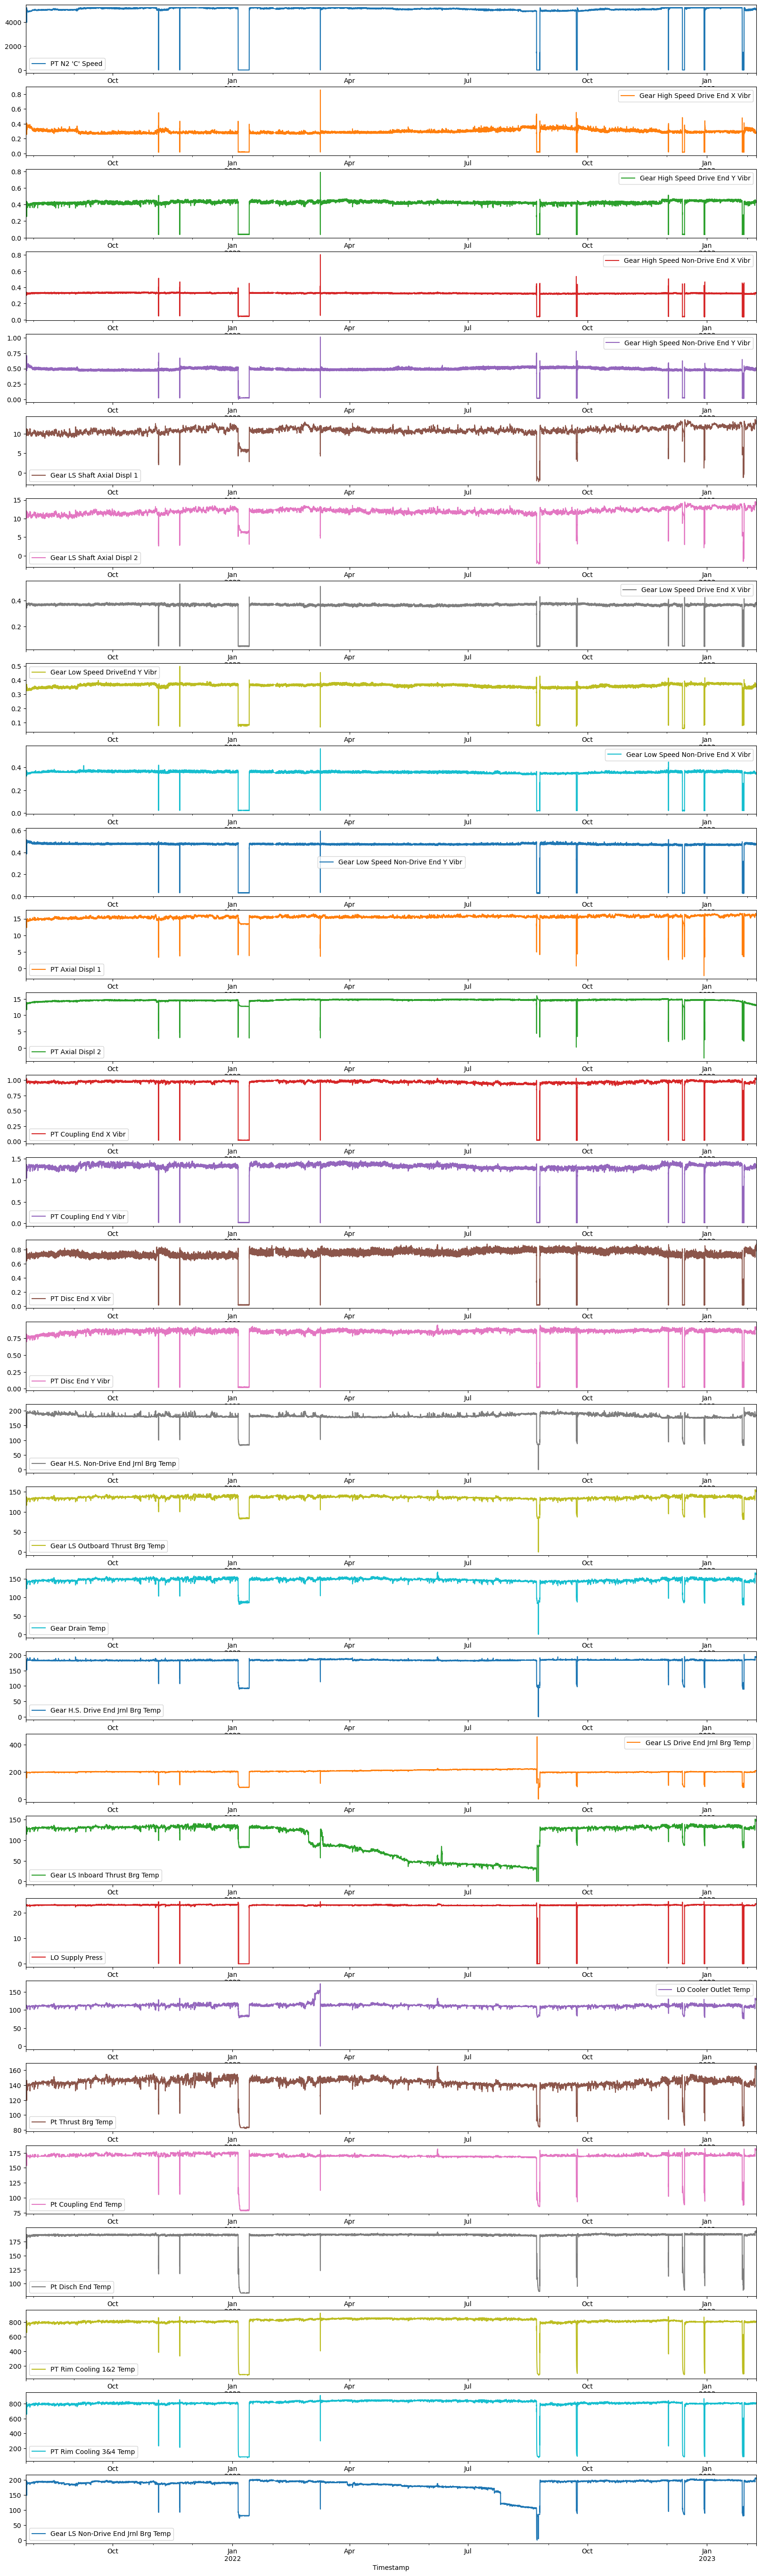

In [5]:
df.plot(x='Timestamp', subplots=True, sharex=False, figsize=(20,70))

Dapat dilihat bahwa terdapat beberapa titik data dimana kecepatan turbin dengan variabel  "PT N2 'C' Speed" dan seluruh sensor memiliki nilai yang sangat rendah atau mendekati nol. Hal ini dapat menjadi kemungkinan terjadinya mesin mati yang disebabkan adanya kerusakan.

Mencari korelasi antara variabel kecepatan turbin  PT N2 'C' Speed  dengan sensor lain.

<Axes: >

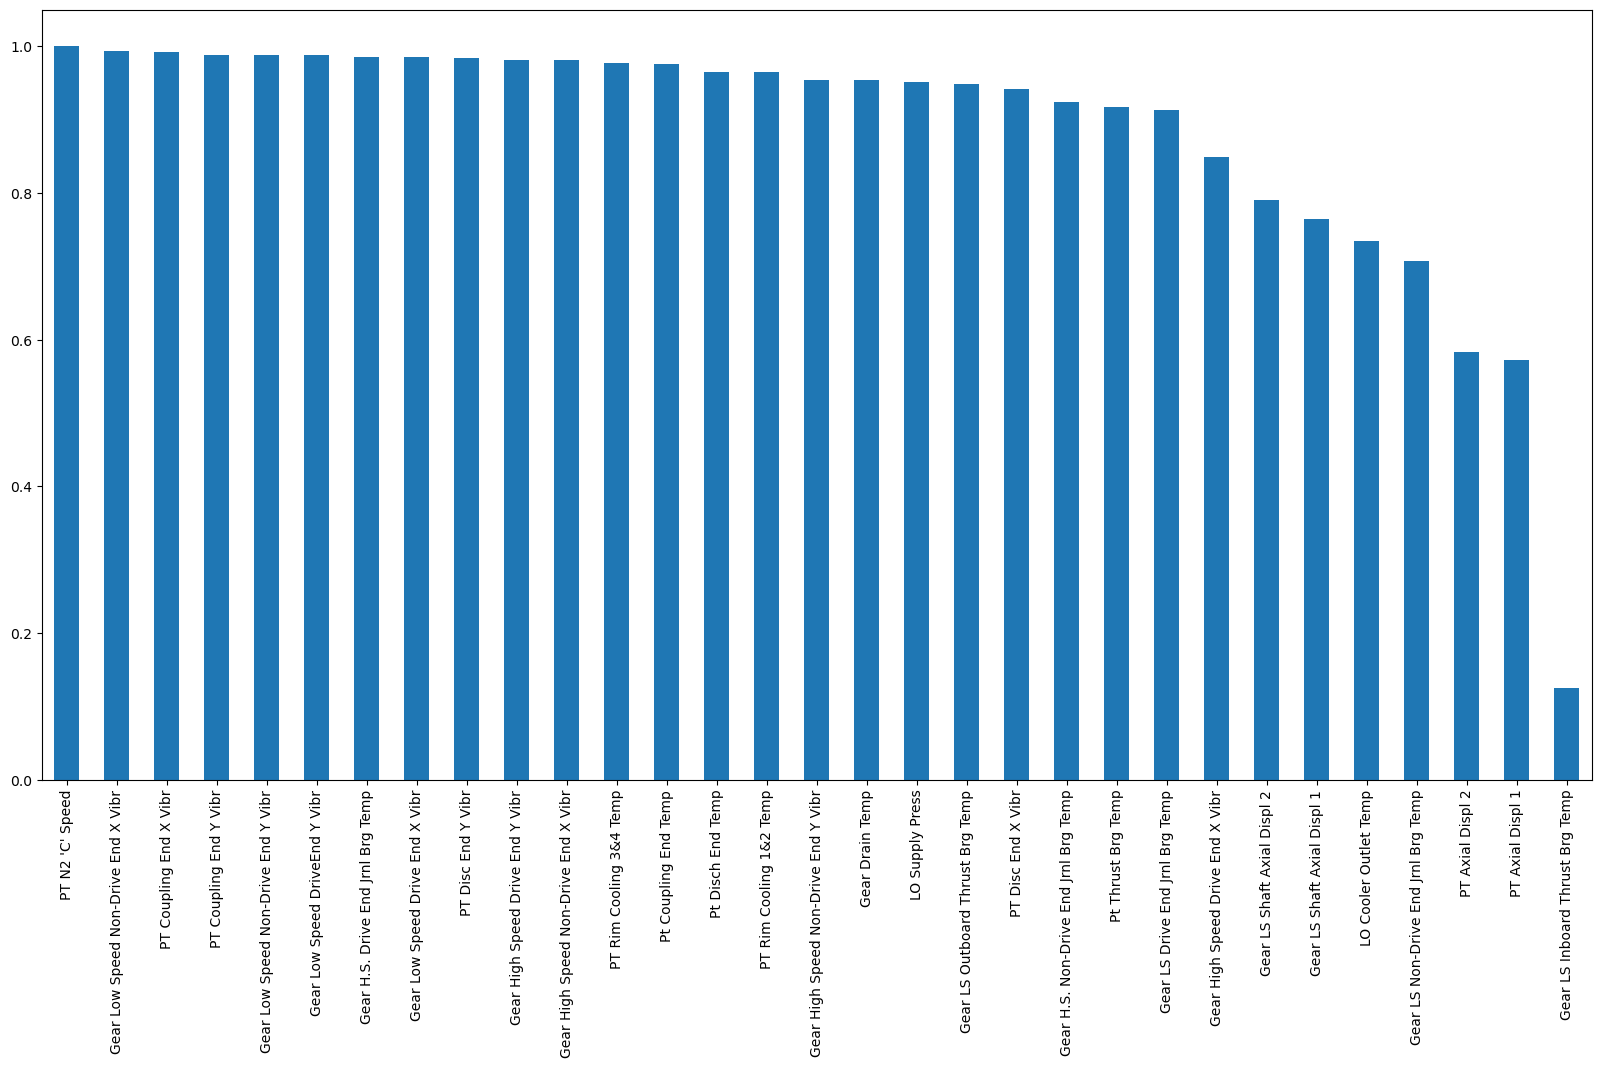

In [6]:
# correlation to  PT N2 'C' Speed  
df_corr = df.drop('Timestamp', axis=1).corr()
df_corr["PT N2 'C' Speed"].sort_values(ascending=False)
df_corr["PT N2 'C' Speed"].sort_values(ascending=False).plot(kind='bar', figsize=(20,10))

Membuat fungsi selector data untuk memudahkan pemilihan data nantinya.

In [7]:
# Helper function for selecting data easier
def data_selector(data, features, time_range_low=None, time_range_high=None):
    if time_range_low != None and time_range_high != None:
        data_selected_time = data.loc[(data['Timestamp'] >= time_range_low) & (data['Timestamp'] <= time_range_high)]
    elif time_range_low != None:
        data_selected_time = data.loc[(data['Timestamp'] >= time_range_low)]
    elif time_range_high != None:
        data_selected_time = data.loc[(data['Timestamp'] <= time_range_low)]
    data_selected = data_selected_time[features]
    return data_selected


In [8]:
features = df.columns.to_list()

Mengambil beberapa sample data yang akan digunakan untuk training. Sample data yang diambil merupakan data yang bersifat stabil dan tidak terjadi kerusakan pada rentang waktu tersebut.

(69928, 32)


array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >], dtype=object)

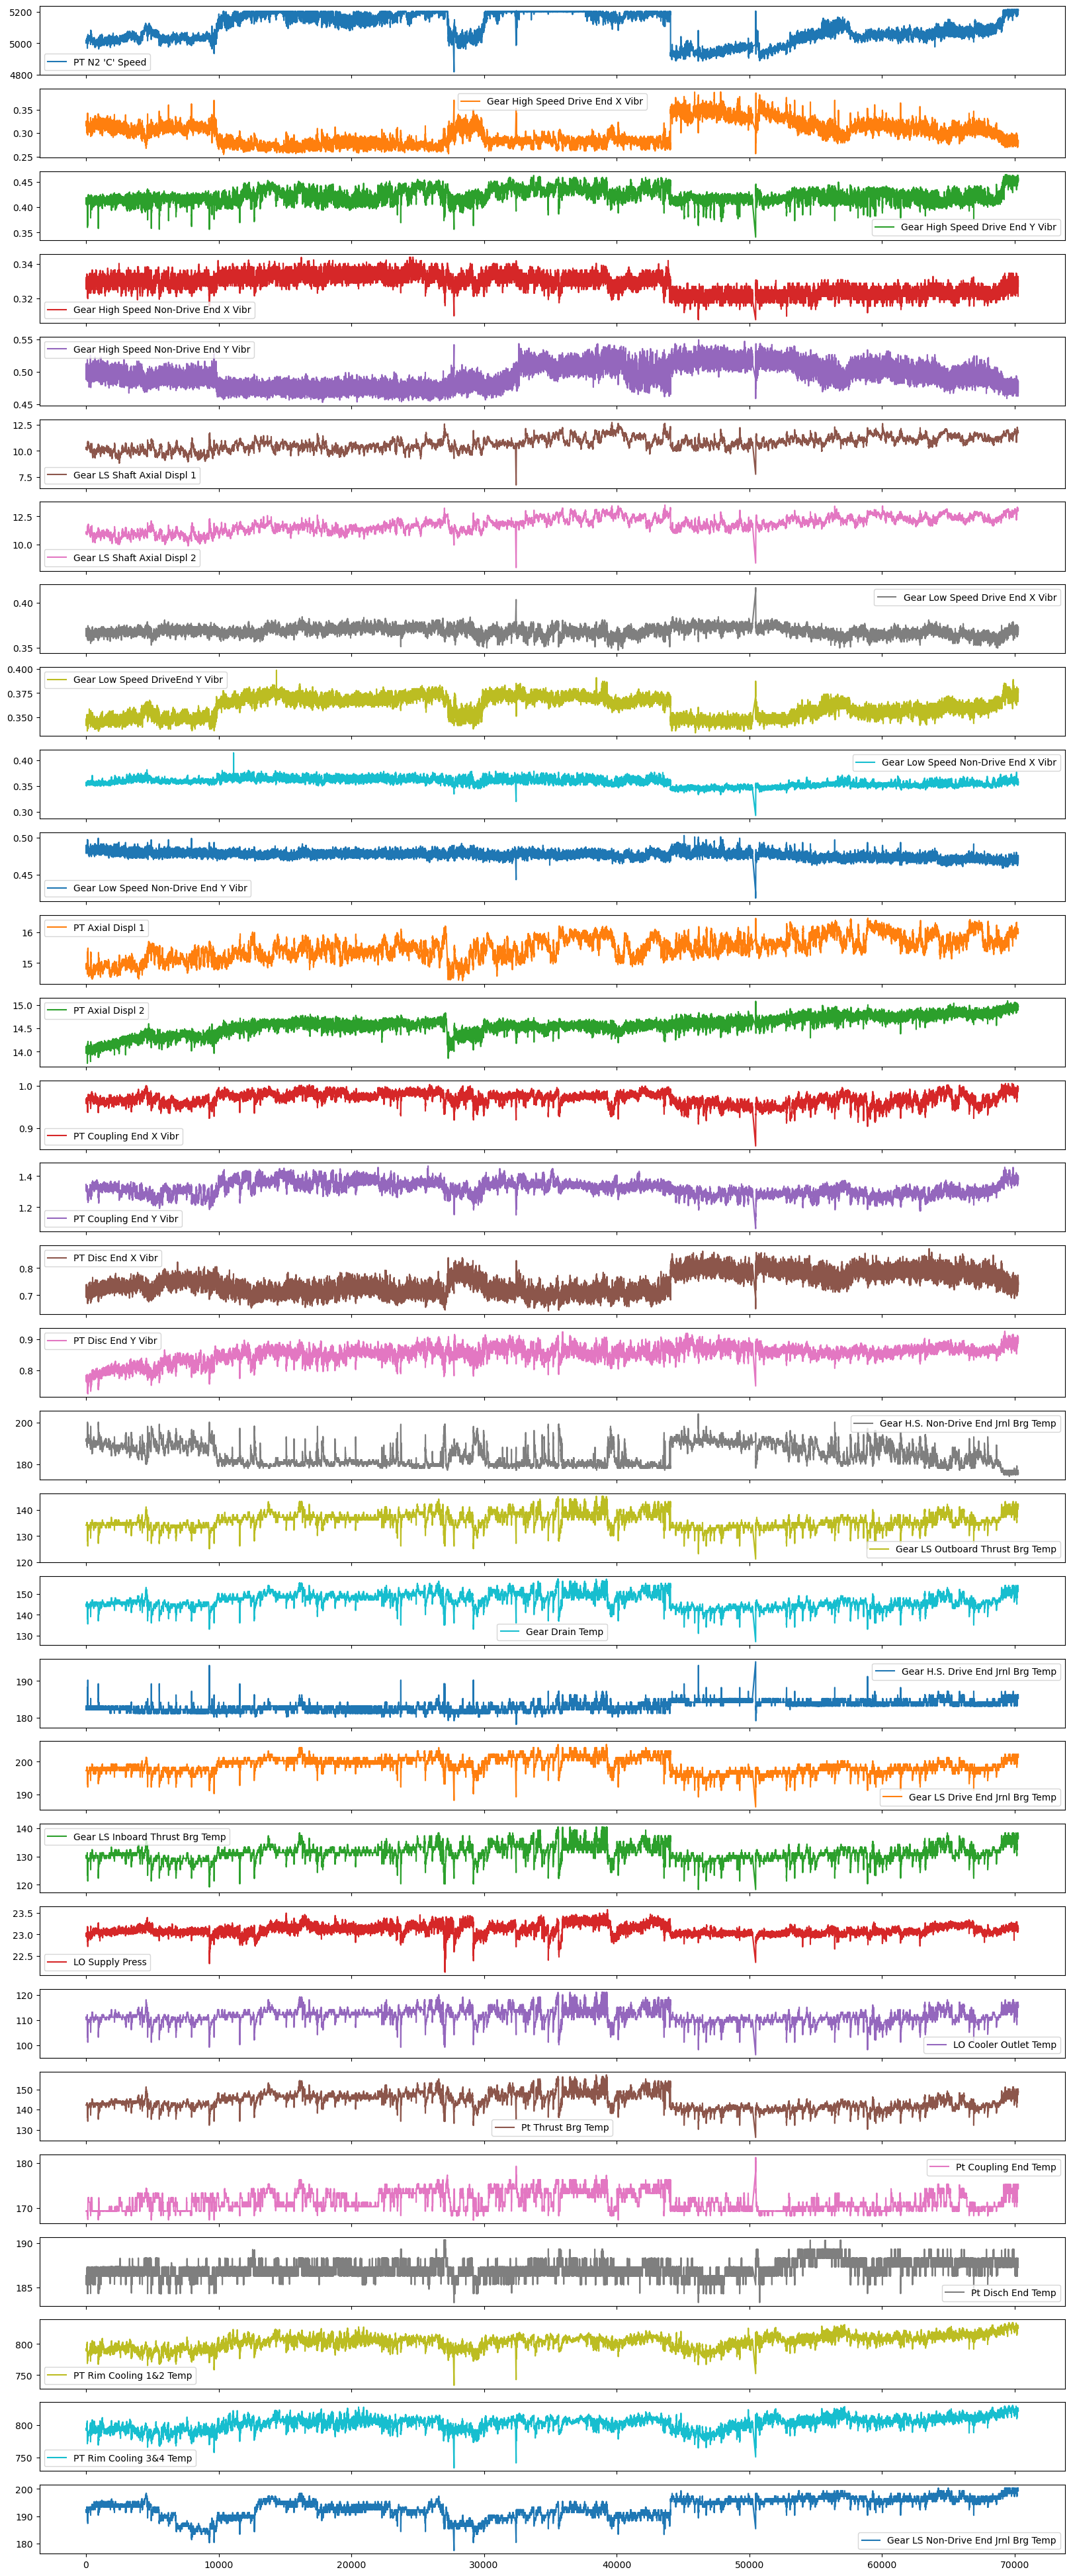

In [9]:
data_selected = data_selector(df, features, '2021-08-01 00:00:00','2021-12-31 23:59:59')
data_selected = pd.concat([data_selected, data_selector(df, features, '2022-09-01 00:00:00','2022-11-30 23:59:59')], ignore_index=True)

features = data_selected.drop('Timestamp', axis=1).columns.to_list()

PT_N2_C_Speed_IQR = data_selected['PT N2 \'C\' Speed'].quantile(0.75) - data_selected['PT N2 \'C\' Speed'].quantile(0.25)
PT_N2_C_Speed_upper = data_selected['PT N2 \'C\' Speed'].quantile(0.75) + 1.5 * PT_N2_C_Speed_IQR
PT_N2_C_Speed_lower = data_selected['PT N2 \'C\' Speed'].quantile(0.25) - 1.5 * PT_N2_C_Speed_IQR

data_selected = data_selected[
    (data_selected['PT N2 \'C\' Speed'] < PT_N2_C_Speed_upper) & 
    (data_selected['PT N2 \'C\' Speed'] > PT_N2_C_Speed_lower)]
print(data_selected.values.shape)
data_selected.drop('Timestamp', axis=1).plot(subplots=True, figsize=(20,50))


Data yang diambil untuk training adalah 69928 baris data dengan rentang waktu bervariasi. Kemudian mengambil data pada rentang waktu 15 Januari 2022 hingga 15 Maret 2022 sebagai data testing.

In [10]:
data_test = data_selector(df, features, '2022-01-15 00:00:00','2022-03-15 23:59:59')
data_test.to_csv('data_test.csv', index=False)

Membuang beberapa outlier dari data training agar prediksi yang dihasilkan lebih akurat. Metode yang digunakan untuk membuang outlier adalah Isolation Forest. [Isolation Forest | Anomaly Detection with Isolation Forest (analyticsvidhya.com)](https://www.analyticsvidhya.com/blog/2021/07/anomaly-detection-using-isolation-forest-a-complete-guide/)


(64368, 32)

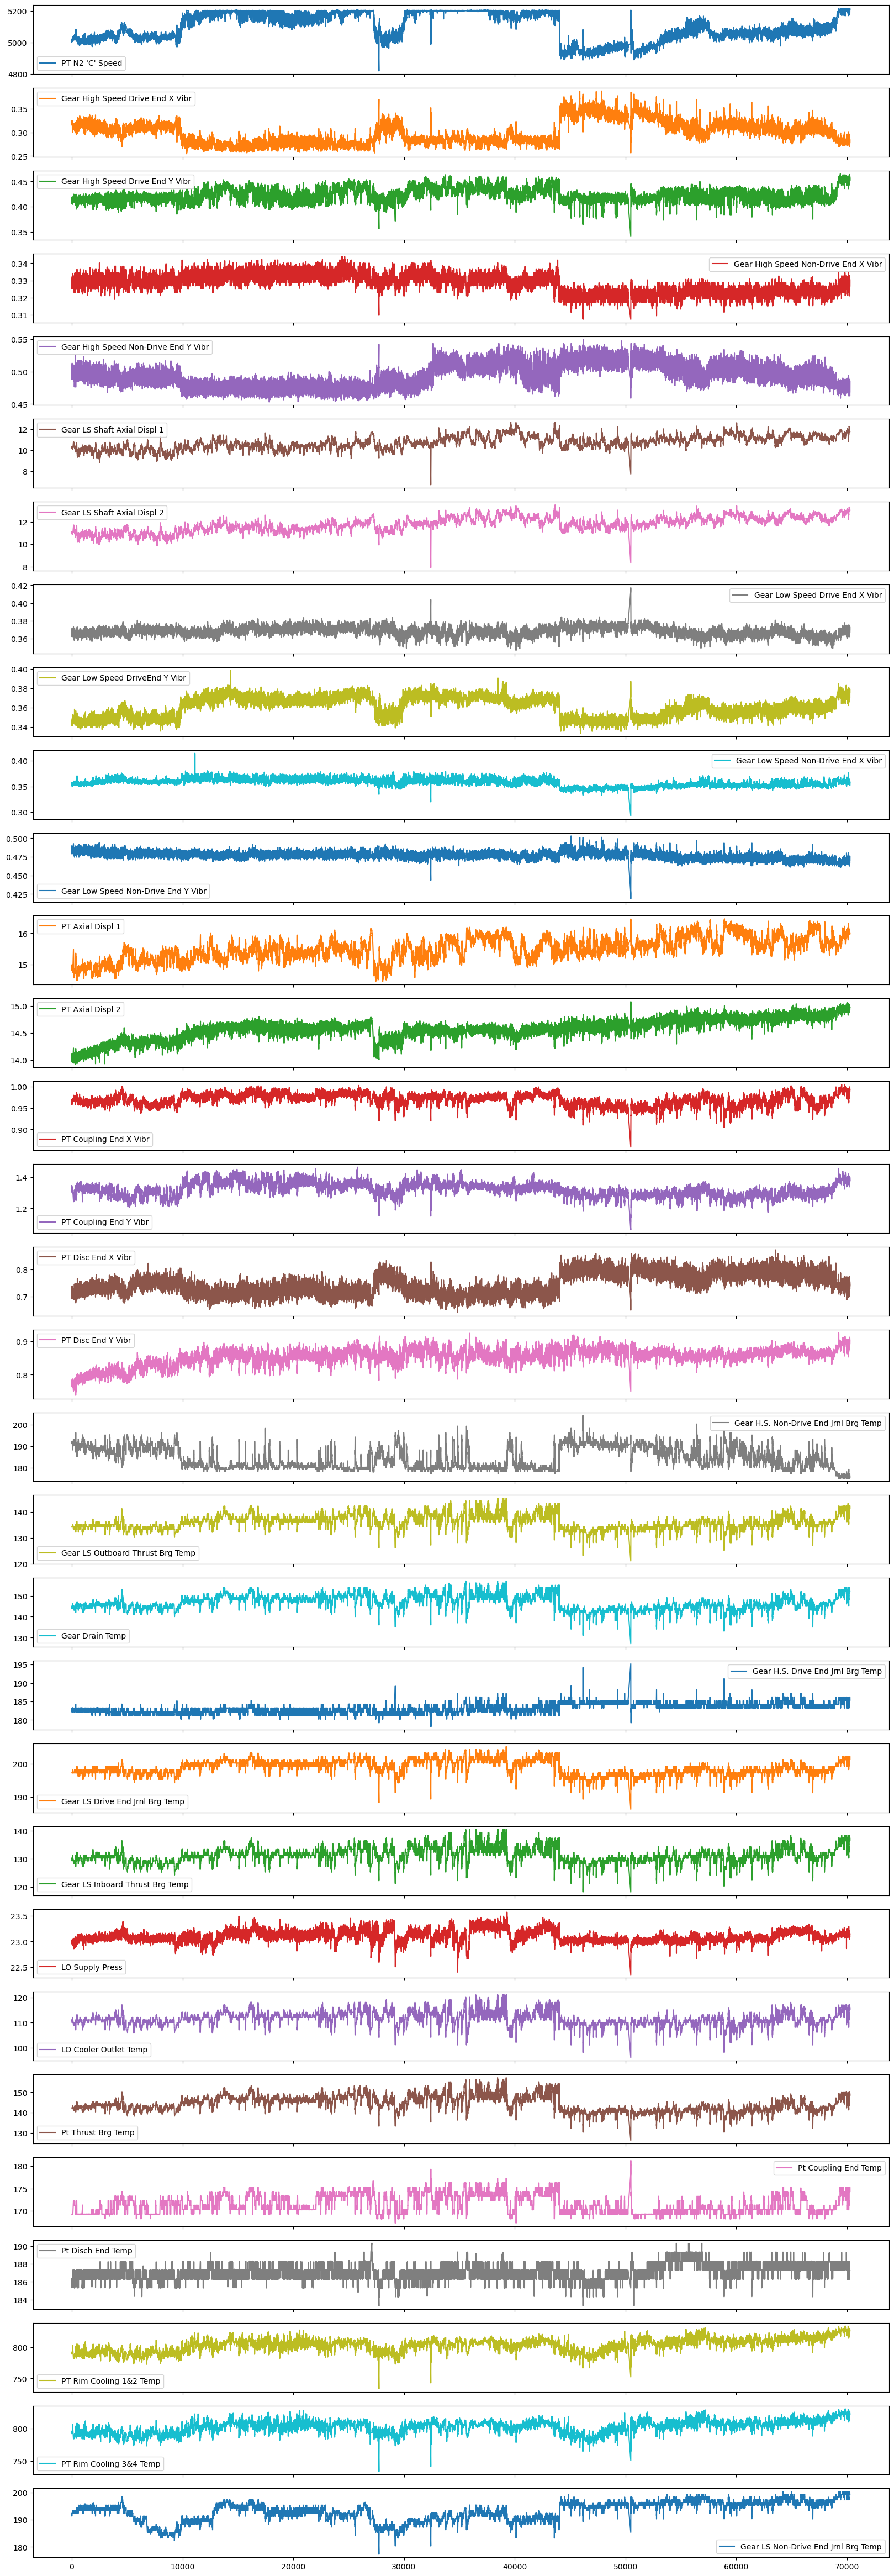

In [11]:
from sklearn.ensemble import IsolationForest

outlier_remove = IsolationForest(contamination=0.08)
outlier_remove.fit(data_selected.drop(['Timestamp','PT N2 \'C\' Speed'], axis=1).values)
data_selected['outlier'] = pd.Series(outlier_remove.predict(
    data_selected.drop(['Timestamp','PT N2 \'C\' Speed'],axis=1).values))
data_selected.drop((data_selected[data_selected['outlier'] == -1]).index, inplace=True)
data_selected.drop('outlier', axis=1, inplace=True)
data_selected.drop('Timestamp',axis=1).plot(subplots=True, figsize=(20,60))

data_selected.values.shape

In [11]:
data_selected.to_csv('train_data.csv', index=False)

# Data Denoising

Meskipun telah dilakukan pemilihan data yang stabil dan pembersihan outlier, terlihat data masih cukup belum stabil pada beberapa sensor. Hal ini akan memengaruhi hasil training untuk model machine learning. Oleh karena itu, terdapat sebuah metode untuk memperhalus data yang juga merupakan sinyal dalam domain waktu dengan melakukan denoising signal.

Terdapat beberapa metode untuk melakukan denoising dalam sinyal sistem, seperti singular value decomposition (SVD), wavelet transform, convolution filtering, dan lainnya. Namun, pada kali ini, kita akan mencoba melakukan denoising data dengan menggunakan model deep learning yaitu Autoencoder, yang lebih tepatnya menggunakan model Denoising Autoencoder.

[ML | Auto-Encoders - GeeksforGeeks](https://www.geeksforgeeks.org/auto-encoders/)

[Denoising Autoencoders Definition | DeepAI](https://deepai.org/machine-learning-glossary-and-terms/denoising-autoencoder)


Melakukan normalisasi data.

In [12]:
train_data = pd.read_csv('train_data.csv')
train_data_t = train_data.drop('Timestamp',axis=1)

In [13]:
from sklearn.preprocessing import StandardScaler

features = train_data_t.columns.to_list()
# Define scaler dictionary
features_scaler = {}
for col in features:
    scaler = StandardScaler()
    # fit and transform data with scaler for all features selected
    data_scale = scaler.fit_transform(train_data_t[col].values.reshape(-1,1))
    data_scale = np.reshape(data_scale, len(data_scale))
    features_scaler['scaler_'+ col] = scaler
    train_data_t[col] = data_scale

Menggunakan library keras, kita akan membuat model denoising autoencoder. Model akan memiliki layer yang terdiri dari 2 layer encoder, 1 layer latent space, dan 2 layer decoder. Layer encoder akan memiliki 30 neuron pada layer 1 setelah layer input dan 20 neuron pada layer 2. Latent space akan memiliki 8 neuron. Layer decoder akan memiliki 20 neuron pada layer 1 dan 30 neuron pada layer 2 menuju output.

In [14]:
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense

def autoencoder_model(dimension):
    model = Sequential()
    model.add(Dense(30, input_dim=dimension, activation='relu'))
    model.add(Dense(20,activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(20,activation='relu'))
    model.add(Dense(30,activation='relu'))
    model.add(Dense(dimension, activation='linear'))
    model.compile(loss='mse', optimizer=optimizers.Adam(0.0005))
    return model
model_dae = autoencoder_model(len(features))
model_dae.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 30)                960       
                                                                 
 dense_1 (Dense)             (None, 20)                620       
                                                                 
 dense_2 (Dense)             (None, 8)                 168       
                                                                 
 dense_3 (Dense)             (None, 20)                180       
                                                                 
 dense_4 (Dense)             (None, 30)                630       
                                                                 
 dense_5 (Dense)             (None, 31)                961       
                                                                 
Total params: 3519 (13.75 KB)
Trainable params: 3519 (1

Kemudian model dilatih dengan input data_train dan output adalah sama dengan input. Model dilatih dengan 30 iterasi (epochs) dan 64 batch size.

In [15]:
from keras.callbacks import EarlyStopping

model_dae.fit(train_data_t.values, train_data_t.values, epochs=30,  verbose=1, callbacks=[EarlyStopping(monitor='loss', patience=5)])

Epoch 1/30

2012/2012 [==============================] - 5s 1ms/step - loss: 0.2888
Epoch 2/30
2012/2012 [==============================] - 3s 1ms/step - loss: 0.1313
Epoch 3/30
2012/2012 [==============================] - 3s 1ms/step - loss: 0.1084
Epoch 4/30
2012/2012 [==============================] - 3s 1ms/step - loss: 0.1003
Epoch 5/30
2012/2012 [==============================] - 3s 1ms/step - loss: 0.0959
Epoch 6/30
2012/2012 [==============================] - 3s 1ms/step - loss: 0.0932
Epoch 7/30
2012/2012 [==============================] - 3s 1ms/step - loss: 0.0913
Epoch 8/30
2012/2012 [==============================] - 3s 1ms/step - loss: 0.0897
Epoch 9/30
2012/2012 [==============================] - 3s 1ms/step - loss: 0.0885
Epoch 10/30
2012/2012 [==============================] - 3s 1ms/step - loss: 0.0874
Epoch 11/30
2012/2012 [==============================] - 3s 2ms/step - loss: 0.0863
Epoch 12/30
2012/2012 [==============================] - 3s 1ms/step - loss: 0.0854


In [16]:
model_dae.save('denoising_autoencoder_model.h5')

c:\Users\farra\anaconda3\envs\machine-learning-1\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Setelah model dilatih, langkah selanjutnya adalah menguji mode untuk memprediksi dataset train yang digunakan sebelumnya saat mode dilatih.

In [17]:
prediction = model_dae.predict(train_data_t, verbose=1)

2012/2012 [==============================] - 2s 980us/step


Setelah proses rescaling kembali data, terlihat hasil dari denoising data menggunakan autoencoder. 

Hasil dari beberapa sensor menujukkan bahwa denoising dapat membuat data menjadi lebih stabil dengan mengubah nilai yang tidak stabil menjadi lebih dekat dengan yang lainnya. Pada grafik, hasil prediksi ditandai dengan warna kuning sedangkan data asli ditandai dengan warna ungu.

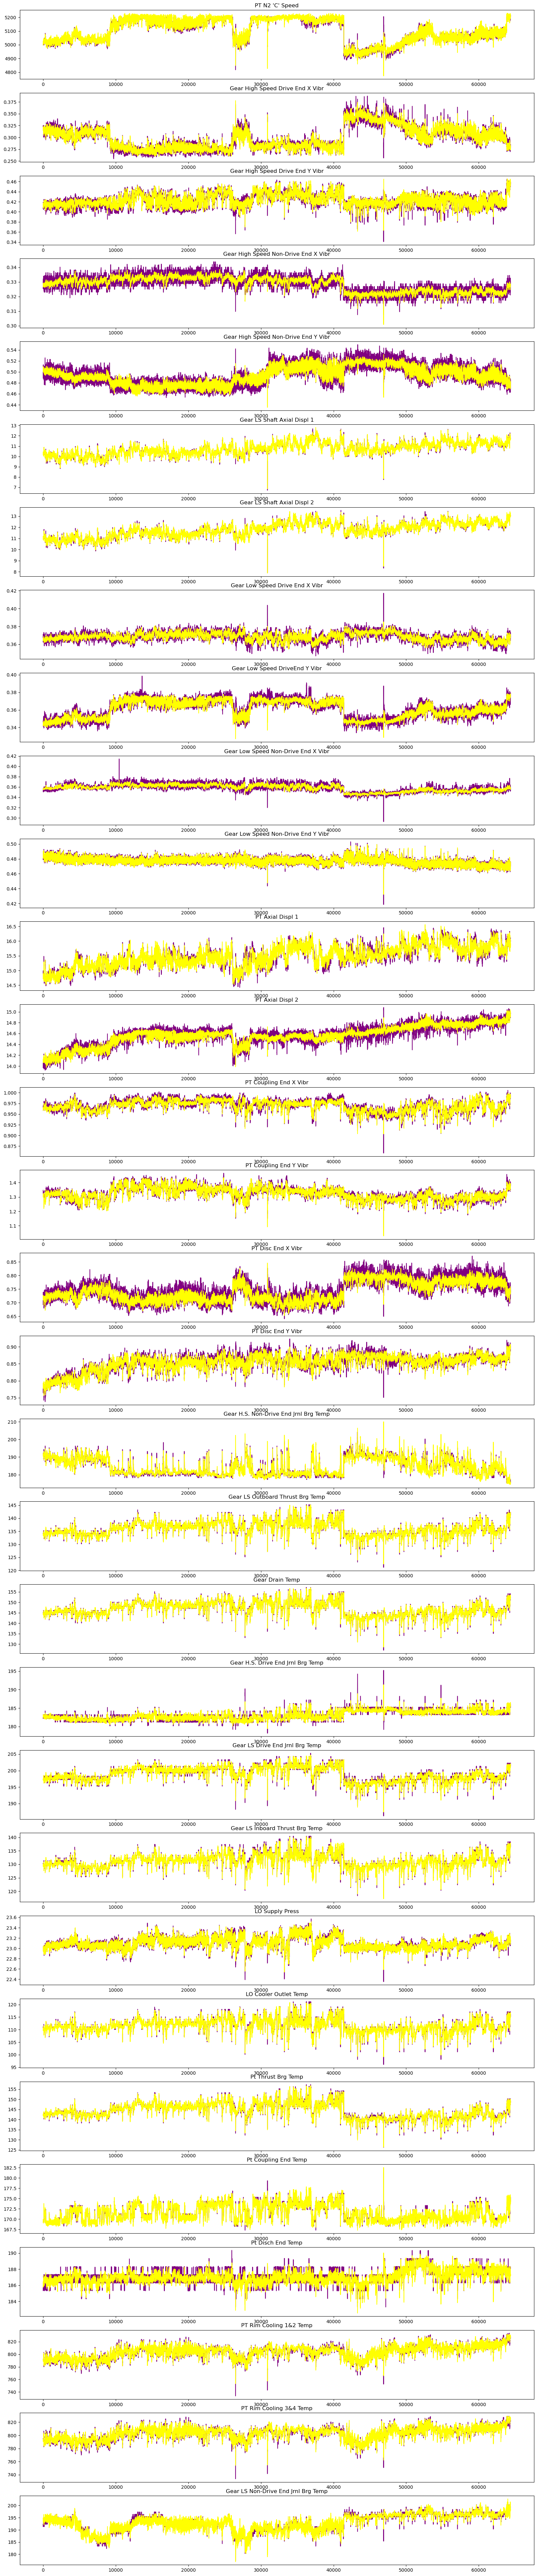

In [18]:
pred = pd.DataFrame(prediction)
for i, col in enumerate(features):
    scaler = features_scaler['scaler_'+ col]
    # fit and transform data with scaler for all features selected
    data_scale = scaler.inverse_transform(train_data_t[col].values.reshape(-1,1))
    data_scale = np.reshape(data_scale, len(data_scale))
    train_data_t[col] = data_scale

    data_scale = scaler.inverse_transform(pred[i].values.reshape(-1,1))
    data_scale = np.reshape(data_scale, len(data_scale))
    pred[i] = data_scale
fig, axs = plt.subplots(nrows=len(features), figsize=(20,100))
for i, col in enumerate(features):
    axs[i].plot(train_data_t[col], color='purple')
    axs[i].plot(pred[i], color='yellow')
    axs[i].set_title(features[i])
plt.show()

In [19]:
train_data_denoise = pd.DataFrame(pred.values, columns=features)
train_data_denoise.to_csv('train_data_denoise.csv')

# Model Training

Model yang digunakan untuk memprediksi kerusakan pada case study ini adalah LSTM (Long Short-Term Memory). LSTM merupakan versi lanjutan dari Recurrent Neural Network yang tujuan dasarnya adalah untuk memperluas cakupan "ingatan" dari sebuah node pada neural network, sehingga dapat mempelajari data dengan ketergantungannya secara jangka panjang yang biasanya ditemukan pada data time series.

In [20]:
train_data = pd.read_csv('train_data_denoise.csv').drop('Unnamed: 0', axis=1).reset_index(drop=True)
# Normalize data
from sklearn.preprocessing import StandardScaler

features = train_data.columns.to_list()
# Define scaler dictionary
features_scaler = {}

for col in features:
    scaler = StandardScaler()
    # fit and transform data with scaler for all features selected
    data_scale = scaler.fit_transform(train_data[col].values.reshape(-1,1))
    data_scale = np.reshape(data_scale, len(data_scale))
    features_scaler['scaler_'+ col] = scaler
    train_data[col] = data_scale


Fungsi berikut ini akan mentransformasikan data, di mana data time series diubah sehingga menjadi bentuk data supervised learning yang memiliki target (data pada waktu sekarang) dan fitur (data pada waktu lampau).

In [22]:
def series_to_supervised(data, n_in=1, n_out=1, lag=0, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        lag: Lags for output observations
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    from pandas import DataFrame
    from pandas import concat

    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('%s(t-%d)' % (col, i)) for col in data.columns]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(lag, n_out+lag, 1):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('%s(t)' % (col)) for col in data.columns]
        else:
            names += [('%s(t+%d)' % (col, i)) for col in data.columns]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

n_in = 12
n_out = 1
lags = 0

Menambahkan fitur baru yang diambil dari data target PT N2 'C' Speed sebanyak 12 yang berisikan data target pada waktu lampau menggunakan fungsi `series_to_supervised`.  Penambahan fitur baru ini didasarkan karena data yang di sampling adalah setiap 5 menit sehingga akan dicoba untuk menelusuri data pada 60 menit ke belakang (60/5=12).

In [22]:
features = train_data.columns.drop('PT N2 \'C\' Speed').to_list()
target = ['PT N2 \'C\' Speed']

# transform time series dataset to supervised learning dataset
train_data_supervised = series_to_supervised(train_data, n_in, n_out, lags)
train_data_supervised.head()

PT N2 'C' Speed(t-12)  Gear High Speed Drive End X Vibr(t-12)  \
12              -0.977498                                0.727875   
13              -0.980863                                0.824039   
14              -0.963382                                0.682071   
15              -0.965425                                0.689949   
16              -0.912116                                0.699945   

    Gear High Speed Drive End Y Vibr(t-12)  \
12                               -0.491126   
13                               -0.505794   
14                               -0.535658   
15                               -0.555025   
16                               -0.528846   

    Gear High Speed Non-Drive End X Vibr(t-12)  \
12                                    0.251457   
13                                    0.474011   
14                                    0.254445   
15                                    0.209417   
16                                    0.213620   

    Gear High Speed Non-Drive End Y Vibr(t-12)  \
12                                    0.282919   
13                                    0.435474   
14                                    0.319722   
15                                    0.260850   
16                                    0.134445   

    Gear LS Shaft Axial Displ 1(t-12)  Gear LS Shaft Axial Displ 2(t-12)  \
12                          -1.119573                          -1.475489   
13                          -0.997169                          -1.233343   
14                          -1.287097                          -1.618269   
15                          -1.073566                          -1.480536   
16                          -0.817578                          -1.220629   

    Gear Low Speed Drive End X Vibr(t-12)  \
12                              -0.839487   
13                              -1.121091   
14                              -0.747867   
15                              -1.368164   
16                              -1.526208   

    Gear Low Speed DriveEnd Y Vibr(t-12)  \
12                             -1.434744   
13                             -1.456295   
14                             -1.473769   
15                             -1.428725   
16                             -1.335681   

    Gear Low Speed Non-Drive End X Vibr(t-12)  ...  \
12                                  -0.168994  ...   
13                                  -0.129586  ...   
14                                  -0.050048  ...   
15                                  -0.232042  ...   
16                                  -0.306748  ...   

    Gear LS Drive End Jrnl Brg Temp(t)  Gear LS Inboard Thrust Brg Temp(t)  \
12                           -0.869759                           -0.848425   
13                           -0.882369                           -0.861497   
14                           -0.964044                           -0.936385   
15                           -0.892787                           -0.777210   
16                           -0.915873                           -0.813450   

    LO Supply Press(t)  LO Cooler Outlet Temp(t)  Pt Thrust Brg Temp(t)  \
12           -0.939257                 -0.659854              -0.626452   
13           -0.917790                 -0.653572              -0.631622   
14           -0.857697                 -0.764630              -0.693303   
15           -1.177523                 -0.637727              -0.642237   
16           -0.502312                 -0.637064              -0.634216   

    Pt Coupling End Temp(t)  Pt Disch End Temp(t)  PT Rim Cooling 1&2 Temp(t)  \
12                -1.135008             -1.014868                   -1.517416   
13                -1.177716             -1.043884                   -1.453466   
14                -1.435070             -1.301749                   -1.599428   
15                -1.268515             -1.393572                   -1.565818   
16                -1.224883             -1.262481                  

Menggabungkan 12 fitur yang telah dibuat dengan fitur lainnya.

In [23]:
# Split target and feature columns for all sensor
labels_column = []
for col in train_data.columns.to_list():
    labels_column.append([('%s(t)') % (col) for i in range(lags,lags+n_out)])

labels_series = []
for col in target:
    labels_series.append([('%s(t-%d)') % (col, i) for i in range(1,1+n_in)])

labels_column = np.array(labels_column).flatten()
labels_series = np.array(labels_series).flatten()

labels_column = np.concatenate((labels_column, labels_series))


y_train = train_data_supervised[labels_column[0]].reset_index(drop=True).values
X_train = train_data_supervised[labels_column[1:]].reset_index(drop=True).values


Pada LSTM, data yang digunakan harus memiliki dimensi 3, sehingga dilakukan perubahan bentuk dari data.

In [24]:
# reshape input to be 3D
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
y_train = y_train.reshape((y_train.shape[0], 1))
print(X_train.shape, y_train.shape)

(64368, 42, 1) (64368, 1)


Pembuatan model LSTM menggunakan library tensorflow.keras. Model LSTM yang dibuat akan memiliki 1 hidden layer yang berisi 50 neuron LSTM yang memiliki activation function relu, dan 1 output layer dengan 1 neuron.

In [25]:
from keras import optimizers
from keras.models import Sequential
from keras.layers import LSTM, Dense

# LSTM Model
def lstm_model(dimension):
    model = Sequential()
    # LSTM Layer
    model.add(LSTM(100, activation='tanh',input_shape=dimension))
    model.add(Dense(1))    
    model.compile(loss='mse', optimizer=optimizers.Adam(0.0003))
    return model


model = lstm_model((X_train.shape[1], 1))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense_6 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40901 (159.77 KB)
Trainable params: 40901 (159.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Melakukan training model LSTM dengan data yang telah dimodifikasi.

In [26]:
from keras.callbacks import EarlyStopping

model.fit(
    X_train, y_train, 
    epochs=30, 
    verbose=1, 
    callbacks=[EarlyStopping(monitor='loss', patience=5)]
    )

Epoch 1/30
2012/2012 [==============================] - 33s 16ms/step - loss: 0.0330
Epoch 2/30
2012/2012 [==============================] - 30s 15ms/step - loss: 0.0209
Epoch 3/30
2012/2012 [==============================] - 31s 15ms/step - loss: 0.0163
Epoch 4/30
2012/2012 [==============================] - 30s 15ms/step - loss: 0.0125
Epoch 5/30
2012/2012 [==============================] - 30s 15ms/step - loss: 0.0100
Epoch 6/30
2012/2012 [==============================] - 30s 15ms/step - loss: 0.0084
Epoch 7/30
2012/2012 [==============================] - 31s 15ms/step - loss: 0.0076
Epoch 8/30
2012/2012 [==============================] - 32s 16ms/step - loss: 0.0068
Epoch 9/30
2012/2012 [==============================] - 30s 15ms/step - loss: 0.0062
Epoch 10/30
2012/2012 [==============================] - 30s 15ms/step - loss: 0.0057
Epoch 11/30
2012/2012 [==============================] - 31s 15ms/step - loss: 0.0052
Epoch 12/30
2012/2012 [==============================] - 30s 15

In [27]:
model.save(f'model_lstm_{target[0]}.h5')

c:\Users\farra\anaconda3\envs\machine-learning-1\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Model Prediction

Untuk melakukan prediksi model, diambil data yang telah didefinisikan sebelumnya untuk data testing.

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >], dtype=object)

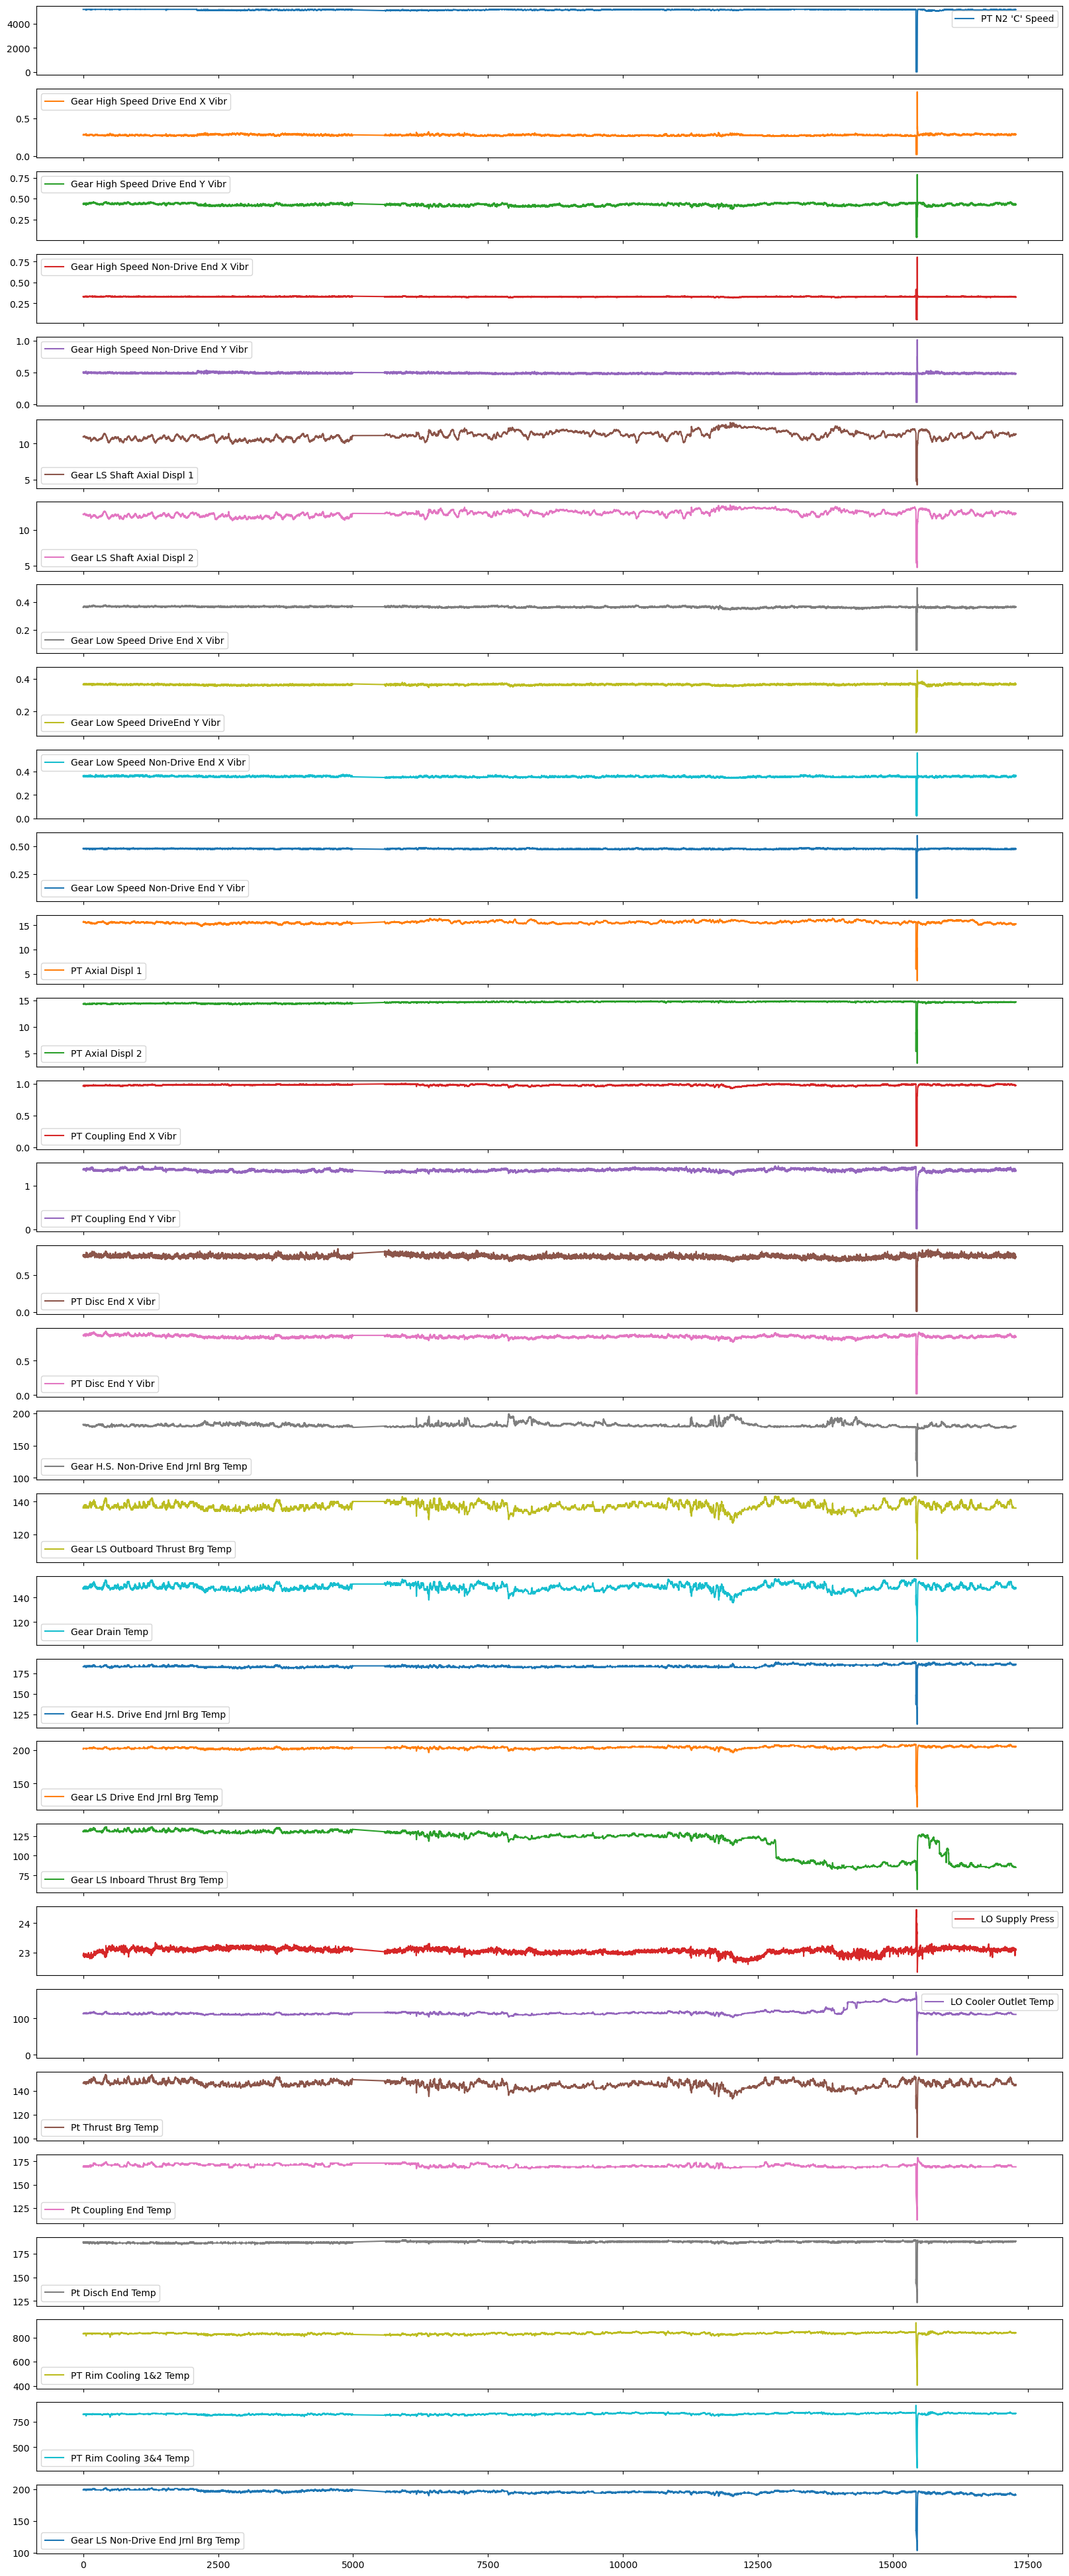

In [29]:
data_test = pd.read_csv('data_test.csv')
data_test.plot(subplots=True, figsize=(20,50))

In [30]:
# Normalize data
from sklearn.preprocessing import StandardScaler

features = data_test.columns.to_list()
# Define scaler dictionary
features_scaler = {}

for col in features:
    scaler = StandardScaler()
    # fit and transform data with scaler for all features selected
    data_scale = scaler.fit_transform(data_test[col].values.reshape(-1,1))
    data_scale = np.reshape(data_scale, len(data_scale))
    features_scaler['scaler_'+ col] = scaler
    data_test[col] = data_scale


Mengubah data testing yang time series menjadi supervised learning seperti yang dilakukan pada saat proses training.

In [31]:
n_in = 12
n_out = 1
lags = 0

features = data_test.columns.drop('PT N2 \'C\' Speed').to_list()
target = ['PT N2 \'C\' Speed']

# transform time series dataset to supervised learning dataset
data_test_supervised = series_to_supervised(data_test, n_in, n_out, lags)


In [32]:
labels_column = []
for col in data_test.columns.to_list():
    labels_column.append([('%s(t)') % (col) for i in range(lags,lags+n_out)])

labels_series = []
for col in target:
    labels_series.append([('%s(t-%d)') % (col, i) for i in range(1,1+n_in)])

labels_column = np.array(labels_column).flatten()
labels_series = np.array(labels_series).flatten()

labels_column = np.concatenate((labels_column, labels_series))

y_test = data_test_supervised[labels_column[0]].reset_index(drop=True).values
X_test = data_test_supervised[labels_column[1:]].reset_index(drop=True).values

# reshape input to be 3D
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
y_test = y_test.reshape((y_test.shape[0], 1))

print("test data :", X_test.shape, y_test.shape)

test data : (17268, 42, 1) (17268, 1)


Sebanyak 17268 data akan digunakan memprediksi terjadinya kerusakan pada mesin turbin. Berdasarkan pada grafik plotting sebelumnya, terlihat bahwa terdapat kerusakan pada bagian akhir dari data. Model yang dibuat dapat mendeteksi kerusakan bila error antara data prediksi dan data sebenarnya sangat tinggi.

In [33]:
model = tf.keras.models.load_model(f'model_lstm_{target[0]}.h5')
prediction = model.predict(X_test, verbose=1)


540/540 [==============================] - 3s 6ms/step


In [34]:
# inverse transform data
for i, col in enumerate(target):
    # define MinMaxScaler
    scaler = features_scaler['scaler_'+ col]
    # fit and transform data with scaler for all features selected
    data_scale = scaler.inverse_transform(y_test)
    data_scale = np.reshape(data_scale, len(data_scale))
    y_test = data_scale

    data_scale = scaler.inverse_transform(prediction)
    data_scale = np.reshape(data_scale, len(data_scale))
    prediction = data_scale

Pada grafik plotting hasil prediksi (bewarna kuning), dapat terlihat bahwa model prediksi LSTM berhasil menangkap pola dari data saat kondisi mesin turbin dalam keadaan baik. Sehingga saat terjadi kerusakan, perbedaan antara data yang asli dan hasil prediksi sangat besar dan memiliki error yang tinggi.

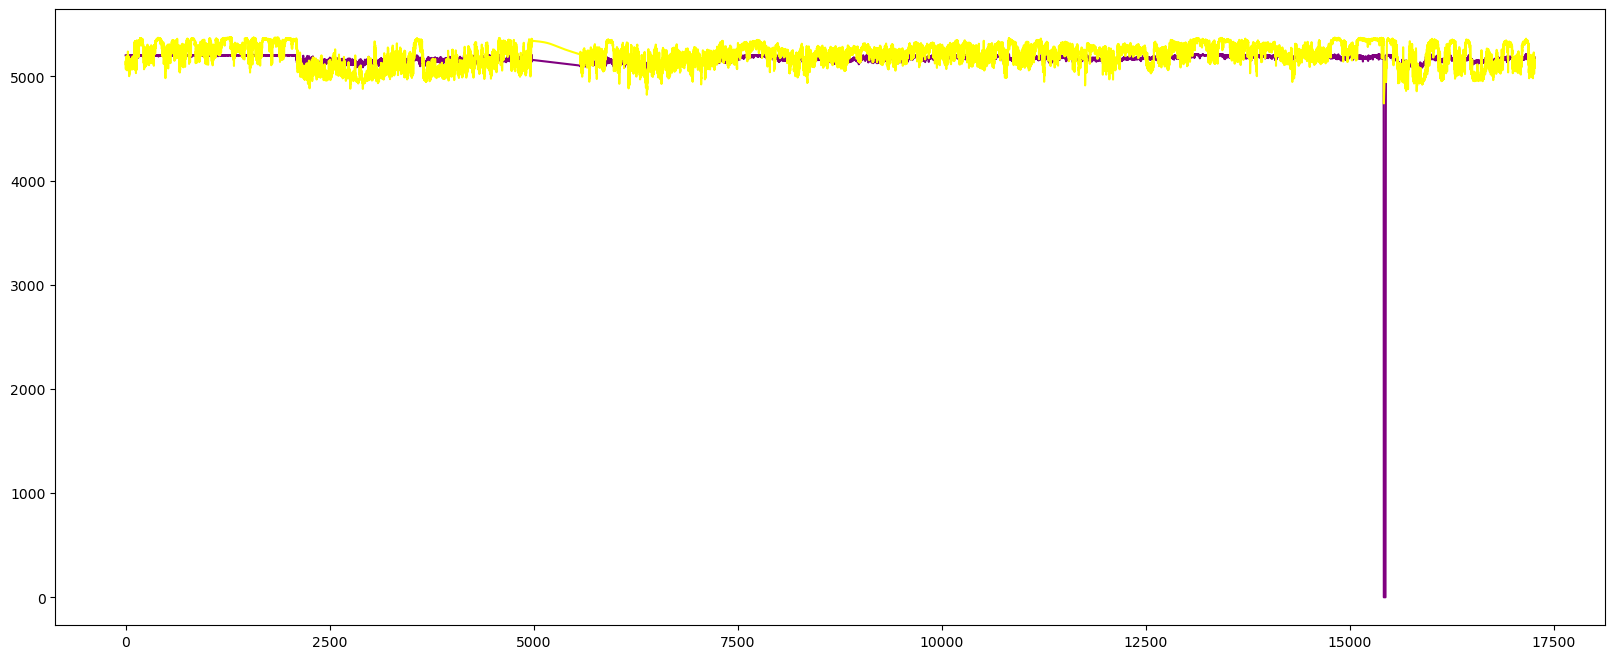

In [36]:
plt.figure(figsize=(20,8))
plt.plot(y_test, color='purple')
plt.plot(prediction, color='yellow')

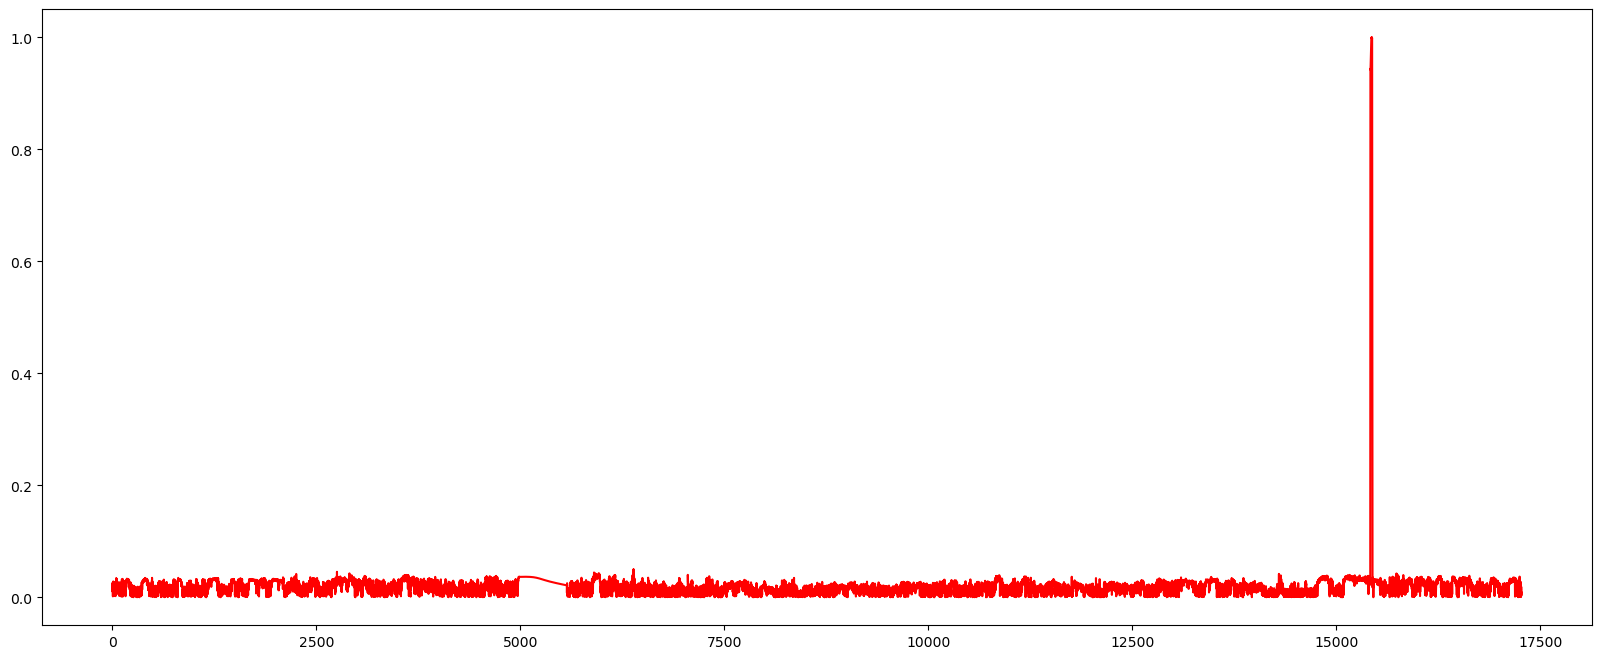

In [40]:
# error plot between y_test and prediction in range 0 - 1.0
error = np.abs(y_test - prediction)
error = error / np.max(error)
plt.figure(figsize=(20,8))
plt.plot(error, color='red')